In [701]:
# inputs

#path to the .csv file created from the VeTrans output
haps_path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/VeTrans/by_protein/n_haps_F/Inference_14_0.csv"

#path to the Times.in file
times = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/samfire/Times.in"

#name of the protein used for plotting
protein_name = "F Protein"


"F Protein"

In [702]:
# load Julia dependencies

using CSV
using DataFrames
using RCall
using Images
using FileIO
using FilePathsBase
using ImageMagick

# load R dependencies
R"""
# Function to set CRAN mirror and ensure R can download packages
chooseCRANmirror(ind=1) # Selects a default CRAN mirror

# Install the devtools package if not already installed
if (!requireNamespace("devtools", quietly = TRUE))
  install.packages("devtools")

# Load the devtools package
library(devtools)

# Install ggplot2 and viridis with dependencies
install.packages(c("ggplot2", "viridis", "tidyverse", "hrbrthemes", "gganimate", "gifski"), dependencies = TRUE)

# Load the packages quietly
suppressPackageStartupMessages({
  library("ggplot2")
  library("viridis")
  library("tidyverse")
  library("hrbrthemes")
  library("gganimate")
  library("gifski")
})
"""

RObject{StrSxp}
 [1] "gifski"      "gganimate"   "hrbrthemes"  "lubridate"   "forcats"    
 [6] "stringr"     "dplyr"       "purrr"       "readr"       "tidyr"      
[11] "tibble"      "tidyverse"   "viridis"     "viridisLite" "ggplot2"    
[16] "devtools"    "usethis"     "stats"       "graphics"    "grDevices"  
[21] "utils"       "datasets"    "methods"     "base"       


In [703]:
# load data

haps_wide = CSV.read(haps_path, DataFrame)

# pass into R
@rput haps_wide 

R"""
library(tidyverse)

times <- colnames(haps_wide)[-1]

haps <- haps_wide %>%
  pivot_longer(
    cols = all_of(times),
    names_to = "Time",
    values_to = "Frequency"
  )
"""

# get back haps dataframe

@rget haps

Row,Haplotype,Time,Frequency
,String,String,Float64
1,GGGCCCCCAATAAGCAATAACAAAGG,1,0.000108336
2,GGGCCCCCAATAAGCAATAACAAAGG,29,1.0e-10
3,GGGCCCCCAATAAGCAATAACAAAGG,50,0.000272864
4,GGGCCCCCAATAAGCAATAACAAAGG,74,1.0e-10
5,GGGCCCCCAATAAGCAATAACAAAGG,83,1.0e-10
6,GGGCCCCCAATAAGCAATAACAAAGG,99,2.44527e-5
7,GGGCCCCCAATAAGCAATAACAAAGG,111,1.0e-10
8,GGGCCCCCAATAAGCAATAACAAAGG,119,1.0e-10
9,GGGCCCCCAATAAGCAATAACAAAGG,125,0.0925662


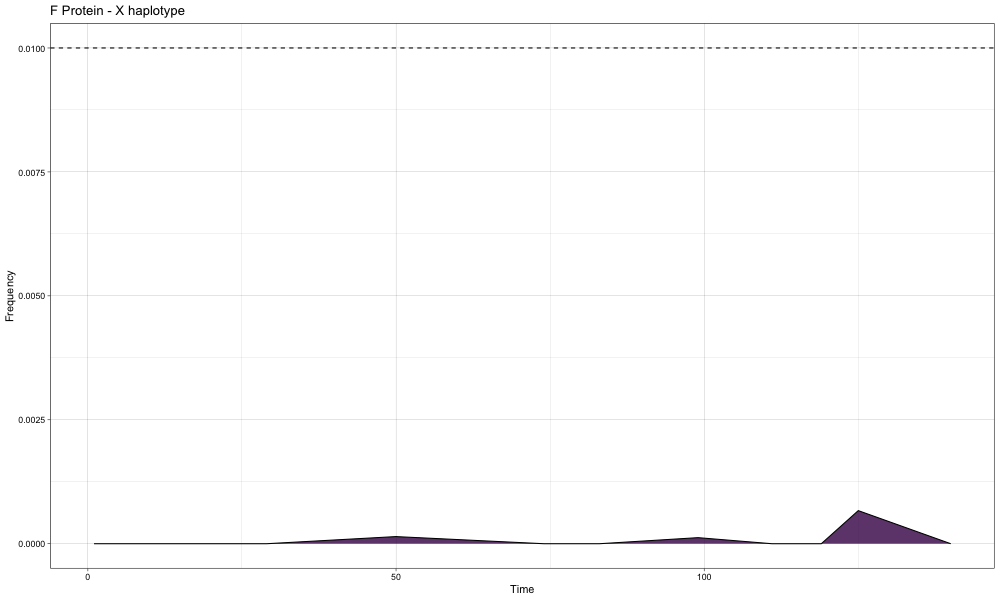

In [704]:
# plot to check X haplotype frequencies

@rput haps # pass back to R
@rput protein_name

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""

p <- haps %>% filter(str_detect(Haplotype, "^X+$")) %>% 
    ggplot(aes(x = as.numeric(Time), y = as.numeric(Frequency), fill = Haplotype)) + 
    geom_area(alpha = 0.8, linewidth = 0.5, colour = "black") +
    geom_hline(yintercept = 0.01, linetype = "dashed", color = "black") +
    theme_linedraw() +
    labs(title = paste(protein_name, "- X haplotype"), x = "Time", y = "Frequency") +
    theme(legend.position = "none") +
    scale_fill_viridis(discrete = TRUE, direction = 1)

png(filename = $output_path, width = 1000, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)

    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
else
    println("File does not exist.")
end

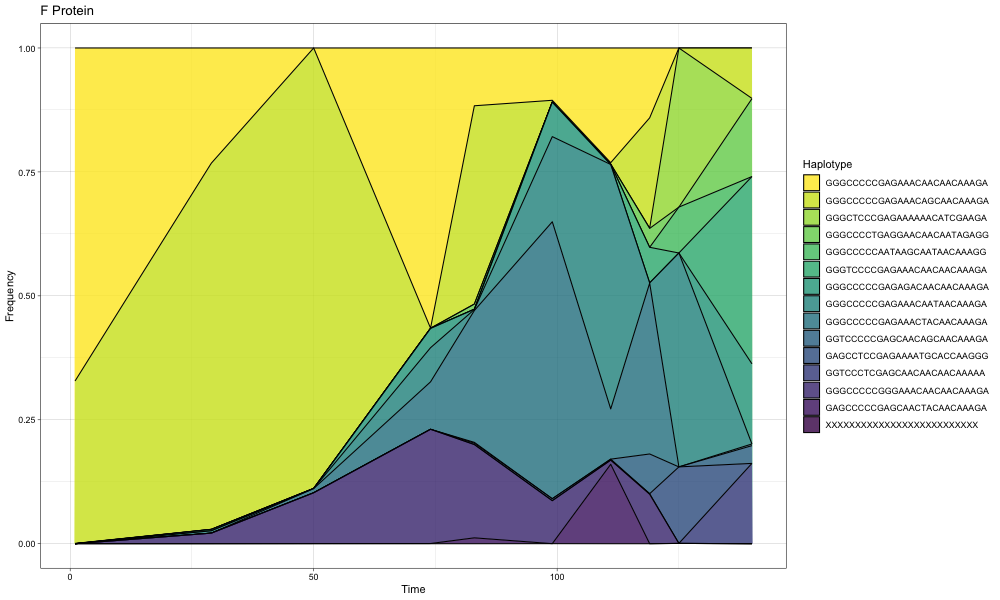

In [705]:
# plot

@rput haps # pass back to R
@rput protein_name

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""
# Sort haplotypes by their initial frequency
first_time_point <- haps %>% 
  filter(Time == min(Time)) %>% 
  arrange(desc(Frequency)) %>% 
  select(Haplotype, InitialFrequency = Frequency)

# Join the initial frequency data back to the main dataset
haps <- haps %>% 
  left_join(first_time_point, by = "Haplotype") %>%
  arrange(desc(InitialFrequency), Time, Frequency)

# Create a color palette with the same number of colors as unique haplotypes
num_haplotypes <- length(unique(haps$Haplotype))
haplotype_colors <- viridis::viridis(num_haplotypes, direction = -1)

# Assign colors based on the order of haplotypes by InitialFrequency
haps$Haplotype <- factor(haps$Haplotype, levels = unique(haps$Haplotype))

# Create the plot
p <- ggplot(haps, aes(x = as.numeric(Time), y = as.numeric(Frequency), fill = Haplotype)) + 
  geom_area(alpha = 0.8, linewidth = 0.5, colour = "black") +
  theme_linedraw() +
  labs(title = protein_name, x = "Time", y = "Frequency") +
  theme(legend.position = "right") +
  scale_fill_manual(values = haplotype_colors)


png(filename = $output_path, width = 1000, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)

    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
else
    println("File does not exist.")
end

In [706]:
using DataFrames
using CSV

# Function to find the consensus haplotype at the minimum time point
function consensus_haplotype(df::DataFrame)
    # Find the minimum time point
    min_time = minimum(df[!, :Time])
    
    # Filter the dataframe for the minimum time point
    filtered_df = filter(row -> row.Time == min_time, df)
    
    # Group by haplotype and sum their frequencies
    grouped_df = combine(groupby(filtered_df, :Haplotype), :Frequency => sum)
    
    # Find the haplotype with the maximum summed frequency
    max_freq_row = grouped_df[argmax(grouped_df[!, :Frequency_sum]), :]
    
    return max_freq_row.Haplotype
end

# Call the function and get the consensus haplotype
consensus = consensus_haplotype(haps)
println("The consensus haplotype at the first time point is: $consensus")

In [707]:
# Function to calculate mismatches
function count_mismatches(haplotype::String, consensus::String)::Union{Int, String}
    mismatches = 0
    for i in 1:length(haplotype)
        if haplotype[i] != consensus[i]
            mismatches += 1
        end
    end
    if mismatches == length(haplotype)
        return "X"
    else
        return mismatches
    end
end

# Add new column with mismatch count
haps.Mismatches = [count_mismatches(row.Haplotype, consensus) for row in eachrow(haps)]

println(haps)

# Group the DataFrame by the 'Mismatches' column
@rput haps
R"""
# Grouping by Time and Mismatches, then summing Frequency
haps_mismatched <- haps %>%
    group_by(Time, Mismatches) %>%
    summarize(Frequency = sum(Frequency), .groups = 'drop')
"""

@rget haps_mismatched

Row,Time,Mismatches,Frequency
,String,Any,Float64
1,1,5,0.000288598
2,1,1,0.327615
3,1,3,2.0e-10
4,1,8,1.0e-10
5,1,4,0.000337723
6,1,0,0.671759
7,1,X,1.0e-10
8,111,5,0.000839678
9,111,1,0.605561


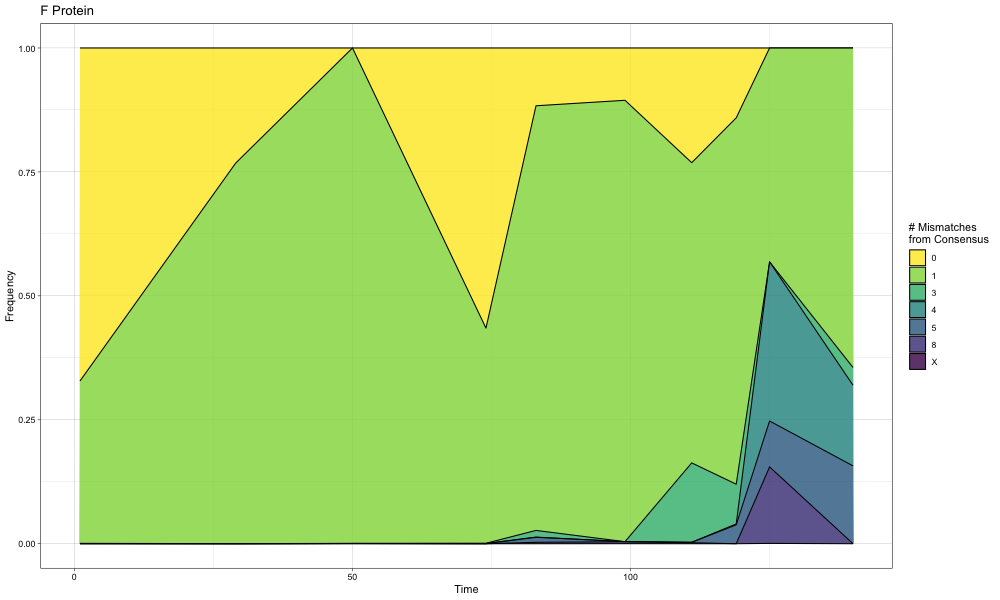

In [708]:
# area plot for counts of mutations
# plot

@rput haps_mismatched # pass back to R
@rput protein_name

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""
# Ensure columns are of correct types
haps_mismatched$Frequency <- as.numeric(unlist(haps_mismatched$Frequency))
haps_mismatched$Mismatches <- as.factor(as.character(unlist(haps_mismatched$Mismatches)))
haps_mismatched$Time <- as.numeric(unlist(haps_mismatched$Time))

p <- haps_mismatched %>% arrange(desc(Time)) %>% 
    ggplot(aes(x = as.numeric(Time), y = Frequency, fill = as.factor(Mismatches))) + 
    geom_area(alpha = 0.8 , linewidth = 0.5, colour = "black") +
    theme_linedraw() +
    labs(title = protein_name, x = "Time", y = "Frequency", fill = "# Mismatches\nfrom Consensus") +
    theme(legend.position = "right") +
    scale_fill_viridis(discrete = TRUE, direction = -1)

png(filename = $output_path, width = 1000, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
img = load(output_path)
display(img)

  
# Delete the temporary image file after displaying
rm(output_path; force = true)
println("Temporary file deleted successfully.")
else

println("File does not exist.")

end

In [709]:
# Function to calculate Hamming distance between two strings
function hamming_distance(s1::String, s2::String)::Int
    return sum(c1 != c2 for (c1, c2) in zip(s1, s2))
end

# Function to group and order haplotypes by Hamming distance, starting with the consensus sequence
function group_haplotypes(strings::Vector{String}, consensus::String)
    # Ensure all strings are of the same length as the consensus sequence
    if any(length(s) != length(consensus) for s in strings)
        error("All strings must be the same length as the consensus sequence")
    end
    
    # Remove the consensus sequence from the list of strings if present
    remaining_strings = setdiff(strings, [consensus])
    
    # Initialize groups with the consensus sequence starting each group
    groups = [[consensus]]
    
    # Set to keep track of used sequences
    used_sequences = Set([consensus])
    
    # Function to find the closest strings to a given string from a list
    function find_closest_strings(s::String, candidates::Vector{String})
        distances = [(candidate, hamming_distance(s, candidate)) for candidate in candidates]
        sorted_candidates = sort(distances, by=x -> x[2])
        min_distance = sorted_candidates[1][2]
        return [c[1] for c in sorted_candidates if c[2] == min_distance]
    end
    
    # Build groups by progressively adding sequences with the smallest possible Hamming distance
    while !isempty(remaining_strings)
        # Get the last group
        current_group = last(groups)
        last_sequence = last(current_group)
        
        # Find the closest sequences to the last sequence
        closest_sequences = find_closest_strings(last_sequence, remaining_strings)
        
        # If there are multiple closest sequences, they branch in the group
        for seq in closest_sequences
            if seq in used_sequences
                continue  # Skip sequences that have already been placed in a group
            end
            new_group = current_group[1:end] # Clone the current group
            push!(new_group, seq)
            push!(groups, new_group)
            push!(used_sequences, seq)  # Mark this sequence as used
            deleteat!(remaining_strings, findfirst(x -> x == seq, remaining_strings))
        end
    end
    
    # Return the list of groups
    return groups
end

# Merge groups where one group is a subset of another
function merge_groups(groups)
    merged_groups = []
    
    # Sort groups by length (longest first) to prioritize larger groups during merging
    sorted_groups = sort(groups, by = length, rev = true)
    
    for group in sorted_groups
        merged = false
        for i in 1:length(merged_groups)
            if all(g -> g in merged_groups[i], group[2:end])  # Exclude the first sequence from duplication check
                merged_groups[i] = union(merged_groups[i], group)
                merged = true
                break
            end
        end
        if !merged
            push!(merged_groups, group)
        end
    end
    
    return merged_groups
end

# Extracting the Haplotype column as a list
haplotype_list = haps.Haplotype

# Filtering out entries that consist entirely of Xs
filtered_haplotype_list = filter(x -> !(all(c -> c == 'X', x)), haplotype_list)

# Establish consensus at time 0
consensus = consensus_haplotype(haps)

# Group by Hamming distance
groups = group_haplotypes(filtered_haplotype_list, consensus)

# Merge groups where one group is a subset of another
merged_groups = merge_groups(groups)

# Initialize an empty DataFrame
grouped_haps = DataFrame(Group = String[], Haplotype = String[])

# Iterate over the grouped vector and populate the DataFrame
for (i, group) in enumerate(merged_groups)
    println("Processing Group $i: ", group)  # Debugging line
    for haplotype in group
        push!(grouped_haps, (string("Group_", i), haplotype))
    end
end

# Apply the function to calculate Hamming distance and create the new column
grouped_haps.ham_dist = [hamming_distance(row.Haplotype, consensus) for row in eachrow(grouped_haps)]

# Convert Julia DataFrames to R dataframes
@rput grouped_haps
@rput haps_wide

# Use Tidyverse in R to join the dataframes by `Haplotype`
R"""
library(dplyr)

# Ensure Haplotype columns are of the same type (if not already)
grouped_haps <- grouped_haps %>% mutate(Haplotype = as.character(Haplotype))
haps <- haps %>% mutate(Haplotype = as.character(Haplotype))

# Join the dataframes on the Haplotype column with many-to-many relationship handling
grouped_haps <- left_join(grouped_haps, haps, by = "Haplotype", relationship = "many-to-many")
"""

# Bring the result back to Julia
@rget grouped_haps

Row,Group,Haplotype,ham_dist,Time,Frequency,Mismatches
,String,String,Int64,String,Float64,Any
1,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,1,0.671759,0
2,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,29,0.232206,0
3,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,50,1.00261e-10,0
4,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,74,0.565105,0
5,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,83,0.11658,0
6,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,99,0.105521,0
7,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,111,0.231366,0
8,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,119,0.140912,0
9,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,125,1.0e-10,0


HTML{String}("<img src=\"data:image/gif;base64,R0lGODlhWAJYAoAAAAAAAAAAACH/C05FVFNDQVBFMi4wAwEAAAAh/gdnaWYuc2tpACH5BAQUAAAALAAAAABYAlgCh////wAAAOfn5+bm5v7+/v39/f3lHtzc3HR0dKOjo3d3d2pqaurq6vz8/Pr6+ujo6Ozs7Pv7++/v7/Ly8vn5+ff39/Pz8/j4+Onp6fX19fb29u3t7evr6/Hx8bDgUvT09O7u7vDw8PzlHuTk5OXl5e7jHwQEBCUlJQ4ODhMTEyEhITU1NYODgxwcHDk5OampqeHh4dfW10BAQCcnJysrK1paWkxMTGBgYLe3t1CzjEuek1ZWVr/iS2XHe23LdXvSbVa7hl5Jh4bWaF5Egk9+lY6Ojk6DlZfbXl89ehgYGE2KlVJSUkymkVpYkB8fH10zcEVFRXl5eT09PdnZ2bm5uWRkZDExMcLCwq3dTdLR0q2trV0zatvb21djkwkJCePj49TU1M7OzoiIiJOTk0ualUlJSXt7ey8vL8vLy09PT/3nHm5ubsXFxYuLi7u7u56enqGhod/f3v/+7eDoRdjnRsvmSbGxsX9/f1ZnlE5OTrThUKfeVl9BfkyTlY7ZY1q+g+/pRkuWlVNxlU2OlVzBgnZ2dkyRlfXpSFF4lV1TjFZqlE2sj+foRU6ujaHdWllckVK2iGDCfllfkU2qj1F7lUuiktLlRlRulV1WjV5OiVJ0lU2HlV5Qi1VslVF2lV84dmdnZ+Lzvf3rS5ubm5eXl+Li4vzkHrrM1XFxcarcRrjW087C0rW1tXPPc/3wd73kZ12inrne0sDny7+wyLzC1MDAwKampr6+vvLkH9Dvw7640MnJyff2td/X4er30f3+9/LsX3TLjWe/l6jiqP3kH/j98WWPoZSeuvL64mqFo3FMgc/l3W9pm0SsgsfHx2E5bX21srXiXL7eLefiIP7pOkB0jZfNt4rWhXJWjGKYoXFflWK0nWl8oc7sk9bsrO/29P7//qTFxGKpojiMiKfgcJbceG1yn///3sbnhf/0l/7nLvrkINzn4Ye4t5J5mWatpPf8+sTV1SuGgiGAfNvhIfn6+arZxtPr4ej18O7q797r6+fm5yB/e0oeV5ujv+Pr7wj/AAEIHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKHEmypMmTKFOqXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0qc8iUMfYwnCxwhinWLNq3cq1q0ATUnbYoOHlTcUGNVJ4Xcu2rdu3LE24GTjGS4yJYFa0UAu3r9+/gAMflEuQBgIAEe6c8DLjBQAFUQbaoEKQhZhbfAVr3sy5M1LCA6uUATDKCZcOd1BEwJHCAQAwKDQYvJLZs+3buHO7BC3wzgoAAuIA2PAiAIgCLewAKFTlYK3auqNLn06dIm8ANXYA4HCjRQsbATgA/4iyAzkb59Crq1/PfjpvCSlIAdhRBsbrAAwATPHC6gTC5+0FKOCAm5lgSylTUCHDDBUAUMZhBNwQwAgCSTEDC/+lR+CGHHbYlAkBBGBCC1UIINAVM5zghBhJUAbAGwHYh56HNNZoo1MCFFDQG6Pd6OOPQDYFAylO4BDkkUgm6RMXUMin5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcGJUhgJ01mnnnXjmqeeefPbp55+ABirooIQWauihiCaq6KKMNuroo5DqiQqNC8Rp6Y+HeVjppZzSmGmHm3YqKoGfchjqqKiyV+qGp6bq6nSrEv/Y6qu04hbrgLPWqitntwqY667AAtZrgL8Ga+xbw7ZX7LHMepUse8s2K21Wz64X7bTYLlWtetdm661R21bX7bfkBhUudeOWqy5P506X7rrw3tSudO/Ga69M80ZX7738tpSvbvv2KzBK/+YW8MAIj1Qwbgcn7LBHC9/W8MMUZxSxbROT2wAFFWSQwQcWTNBBCBKAAMIGEHCgMgQbgCCBBCF0MIEFH2SgQQUO6FgxQRd7ljGwBERwgQYWhAACBw8MQMIDDJgMs8w013zzBRQ4QMEFFWjwccgikywBBAwIQIIAGEAAQgcfaEBBBAj33NnPqTZwgQUSMDAA2RycbYEGF0T/QMBIBThwQQZFb4D03RCE8AEFOq/rNmdwWxqBBhOAgMHYiWfA+E1y083BAAMwIIEFFTTw7eObRc5mBBnUTQIGG3SggQN/C1UABRmEAIEAoXdQQePHoq6Z6mdSYAEEAzwAwgeuZUXBBMgrz7yxwgtGfJgNaBACAyQwEMLvbrEuAQYDcDDBBbW/Wn1g13dZgQQPCLCBBRRoRsAFE3zOwATNo7o+YO3DUgM+gDwOWMB0uaFAB8gHAg2k71L/+0sAqaRABjpQPQMsoAXYZqkI+mWCTyKABkAQOv5t6AIhEMADQnABOHmwLyBEUgU2MIANZAB4HYqABT4ngfqx6YVwieGP/ygggfJlAEkFsAAGHjABBKIJiG8RYo0aMIE4YMACOESSA0IwABh8IIthgqJbpMihAnwgbCEgQQupZAHl1bBBZBJjW8g4oBkOAARrpFuVMFA/AmTgcyHo35fkyBY6socAH2DaBQdSgAFQyQEPKIgZBcABOHqJkGsxZHUawMUN+NAgEJCNlEIwAYRogAEP+MADs4RJr2hSOhSgYQeceBANQGBKAqClQRxAwhDo0kqt7Morc3PKVK4SIQMAY5AukB+GFKADNfwkMCllJQJMQAAQWKNDRhel5UEkAxjAwBGnqSkqPVMAEuAgRJgJJQIM4JgMuQAEUlmlYHJlmPabwABCAP9PhwhAnUjKwAYqEoF5jjNK9twKPgFjzQFI4JcR6UAHnlTJi1AAaaJ8UkK1slC/WEAAIICoRCJgopg0wAEV+MAEJIAyDjBgifFT2ghIIFOaqhADDGAAB8xGygxcIGcmdWRGmIkBSyJpo1np6Fs+ID+AYoQB2izJ7TLQgaORb2wM2IAEJuBTqlUtAg0owDEJQIACNCACVrsA1j7Qga9hQGxkM9sEZtdPkOhxIxXAaVSBhFSsKJUtGcCmIDVyV5B0TgKfC93o+BYBZX4kcIOr3OWwGQLNOTYjfPRIXhkgTR/11Sl/7coFMMCBzm6kkR1xwAdAwD3KLu6yLTms3cpXWZH/UgSSIdHAAyDg1Bp9timh1UoDNvAA03YklBcpQAU68DkMSICuQ7ndank3P+NGhJQjycAAOlBXUlHTRvosJUlsORHxJQ0C5+tudLXHPe9pALYIySVJCgACAWTUU9/10AUesAHbeiSZDhFhfaXXW60YbwNkY+FDKtDMklCAtAUe0G+ZEtylDPcBeyUJNxWiw8/ZEL5cicAE7PbhhXgTJR/YrnrVM+GlVDgp+rTASth5kAtIQIUK7oyASzhYgbhzxR6hr3071GKlvNgoFeAviEHyz4H4UYMR7kwFHRpVgbbkwRyIcnWKnJQjRxcEGH6JRAFwARJuoAJA9kwDMoBG11TU/yVMFa+AuIwULwelAgKQs0s0MAUBMECVG6Ji0riwZJEQAGxajg6dj2JnnxAAftY9SRKXGIeDeggCMDBimkOi3Q8EaNFGaTRPKIDOTX9EAzys32pt9ADX2LGHLmmAyvxrq/xSJ4UZlvQ1z0wQ1NIIt4z8QDgtrRILDIDY0gF1UUSNEwfAztQciUAR03kQ5HoIuwaRZ54L3ZEIwI7bgVE2UZhtk2veFyUV4MC2E0JeD8kXIdJ2aI9N0gEBGFU34h4KuWfSAAZAANwZQaQiGwJgDlVAPAshwEffnBIKPEAC0O5LvoWy75jg2dMpKYA+PfmQDW/Ihg85JQYwjhIChOABif8WzMSDUnExozwlDZ1lRGhMoB9HxAEGVYkGBnBvz6wcKC1nSQF2GnGLNPShFGkygaw8kYs+4NwkgeREa11O2zhAAFM/yUdDapExE4jhEyFqz
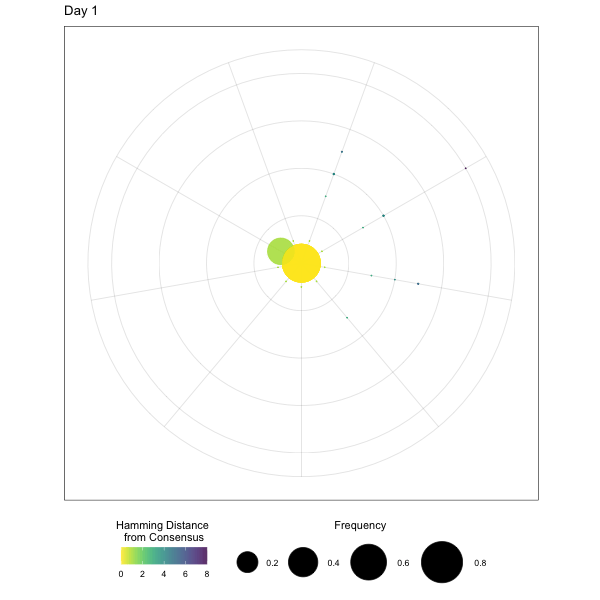

In [710]:
# circles animation

# Define the gif_path by replacing .csv with .gif in haps_path
gif_path = replace(haps_path, ".csv" => "_circles.gif")

# Extract the directory name from gif_path
dir_path = dirname(gif_path)

# Ensure the directory exists
if !isdir(dir_path)
    mkpath(dir_path)  # Create the directory if it doesn't exist
end

# Pass the `grouped_haps` dataframe and `gif_path` to R
@rput grouped_haps
@rput gif_path

# Run the R code to create the animation and save it
R"""
# Find the min and max frequency
global_min <- min(grouped_haps$Frequency, na.rm = TRUE)
global_max <- max(grouped_haps$Frequency, na.rm = TRUE)

# Use these in ggplot with consistent size scale
size_limits <- c(global_min, global_max)
size_range <- c(0, 20)

# Create the ggplot
p <- grouped_haps %>%
    ggplot(aes(x = Group, y = as.numeric(ham_dist), color = as.numeric(ham_dist), size = Frequency)) + 
    geom_point() +
    theme_linedraw() +
    labs(title = 'Day {round(frame_time)}', x = "Group", y = "Hamming\nDistance", size = "Frequency", color = "Hamming Distance \nfrom Consensus") +
    guides(size = guide_legend(title.position = "top")) +
    theme(legend.position = "bottom", 
          legend.title = element_text(hjust = 0.5)) +
    guides(colour = guide_colourbar(title.position = "top", title.theme = element_text(hjust = 0.5))) +
    scale_color_viridis(direction = -1, alpha = 0.8) +
    scale_size_continuous(limits = size_limits, range = size_range) +
    coord_polar(theta = "x", start = 0) +
    ylim(0, max(grouped_haps$ham_dist)) +
    theme(axis.title.x=element_blank(),
          axis.text.x=element_blank(),
          axis.ticks.x=element_blank()) +
    theme(axis.title.y=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks.y=element_blank()) +
    transition_time(as.numeric(Time)) +
    ease_aes('linear')

# Render the animation as a GIF
anim <- animate(p, renderer = gifski_renderer(), width = 600, height = 600, fps = 5, end_pause = 50)

# Save the GIF to the specified path
anim_save(gif_path, anim)
"""

using Base64, IJulia

# Check if the file was saved successfully
if isfile(gif_path)
    println("GIF successfully saved at $gif_path")
    
    # Read the GIF file
    gif_data = read(gif_path)
    
    # Encode the GIF data to base64
    base64_gif = base64encode(gif_data)
    
    # Create an HTML image tag with the base64-encoded GIF
    img_html = """<img src="data:image/gif;base64,$base64_gif" />"""
    
    # Display the HTML directly
    display(HTML(img_html))
else
    println("Failed to save GIF at $gif_path")
end

The next plot requires input from Blanche (https://github.com/cjri/Blanche.git). 

In [711]:
# Define the file paths
blanche_path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/Blanche/F/Consensus0_F_14_haplotypes.dat"
names_path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/Blanche/F/Consensus0_F_14_haplotypes.txt"

# Step 1: Read the .dat file and select the first two columns
df_coords = CSV.read(blanche_path, DataFrame; header=false, delim=" ", select=[1, 2])

# Step 2: Read the .txt file containing the haplotype names
names = DataFrame(Haplotype=readlines(names_path))

# Step 3: Combine the two DataFrames
blanche = hcat(df_coords, names)

# Step 4: Rename the columns to "x", "y", and "Haplotype"
rename!(blanche, [:x, :y, :Haplotype])

# Display the blanche DataFrame
blanche

# join to grouped_haps
grouped_haps = innerjoin(grouped_haps, blanche, on=:Haplotype)

# display the joined dataframe
grouped_haps

Row,Group,Haplotype,ham_dist,Time,Frequency,Mismatches,x,y
,String,String,Int64,String,Float64,Any,Float64,Float64
1,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,1,0.671759,0,-0.253903,0.35885
2,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,29,0.232206,0,-0.253903,0.35885
3,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,50,1.00261e-10,0,-0.253903,0.35885
4,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,74,0.565105,0,-0.253903,0.35885
5,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,83,0.11658,0,-0.253903,0.35885
6,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,99,0.105521,0,-0.253903,0.35885
7,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,111,0.231366,0,-0.253903,0.35885
8,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,119,0.140912,0,-0.253903,0.35885
9,Group_1,GGGCCCCCGAGAAACAACAACAAAGA,0,125,1.0e-10,0,-0.253903,0.35885


HTML{String}("<img src=\"data:image/gif;base64,R0lGODlhWAJYAoAAAAAAAAAAACH/C05FVFNDQVBFMi4wAwEAAAAh/gdnaWYuc2tpACH5BAQUAAAALAAAAABYAlgCh////+Tk5PLy8vHx8ePj43R0dHd3d/j4+Pz8/Ht7e+zs7GxsbAAAAPzlHpzZJ/v7+7m5udfX1/7+/jk5ORwcHCAgIKOjo2VlZSgoKCNge/n6+u7u7jAwMCMjI+Hh4TQARxgYGJ6enktLS9zc3A0NDQoKClZWVnZ2dllZWf3+/b6+vkRERDc3N05OTqioqNLT0yxBeebm5lbFTGPKRB+RdSdReiBveyVWey81dTYeaiKbcDcVYkC6WSpHeTIvc0FBQRERER5+ej4+Ps/Pz+rq6js7O3l5ea2trYSEhIiIiCwsLFFRUZeXl/T19WhoaB6Betra2pGRkSSgb8jIyF5eXsPDwxUVFcvLy7u7u25ubs3NzWFhYfDw8Pf490hISGJiYgQEBNXV1Y6Ojujo6FRUVIGBgaamprGxsTQ0NH5+fmtrayUlJdHR0cHBwbW1taurq4uLi01NTSJke97e3ihMejcKVjYkbTQqcTYEUjYATjcQXefjFzQnb3FxcTcNWi86dyaibG/OPvjlHJbXKjq1XZ7ZJrndG93hFe/jGjKvY3fQOSFqe4bUMSVbex6Mdx95eh9ze0m9VB6Id8vfF7DcHiyoaCimazYaZh6GeKjaIiCWcyJoe9ThFsHeGTazYC+sZo7WLR93e37SNpWVleLi4sbGxrCwsP30np7aLDwLS+zr7JqamqPRxpycnK3fQ6TcPNTvpE3AUVtbW5OTk/b29v34vi48eOz31q2pxcHqs6PFyaW7yfb753OvrUlfjKrcxDxriXp6eqmpqZDEuoVmjj6aiktOh7Diu6iyyJHYk32Gq8nrizuOiz90jObyoDqFiq2hwDGldm/AoHDOZ87jNlSemlnDbkiyglC5fj6og8Dj1e3z9KyXtfbznb7lcUZ+kOT1xbPhWPvnONvxsK/Fz+rnNYLUV09BgVEsb62bu08hYnSZq7PU0VElY5PZTlEzdlA5e8/c4l+Ln9bt5GU+cV00aLa7z+DZ4uXf5182au/x7IS4tnZTgPPw83ZTf/zqWwj/AAEIHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKHEmypMmTKFOqXMmypcuXMGPKnEmzps2bOHPq3Mmzp8+fQIMKHUq0qNGjSJMqXcq0aUcxUKOYGYNRmAenWLNq3cq1KwAwQsjEUVKilcU3DFR4Xcu2rdu3K8FgGRilRJiJTZxYKaEWrt+/gAMLNiiXoJICAB6kWVMCgzAABoINFAGB4BQUBED0Hcy5s+fPRwsP/CICwKoKUAakIfEAAhANAMKQoHVQM+jbuHPrhilaYBoWAGLMAaDABYMNKSicAXDiAkLbu6NLn07dYm8AVEwAUEWFAgURDFQB/whGJnmV55urq1/PnnrvDVaYADDh5eoLBkQAQCnhpkNC6O0FKOCAgoFhBilQQPADBl0A4AViEmzBQAACFYEBEv+lR+CGHHboFBgMMAAGBRfEIFAbGKxBQRIgVAZAKwxchZ6HNNZoY1MxpFBQCF7c6OOPQDrlARMVuBjkkUgmyRMUXoyi5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcGZEhQF01mnnnQaogeeefPbp55+A4tlHoIQWaqifeh6q6KKEDsroo5DamUUBkVb6qKOWZmpoopp2+iemnlp6QgIkLQARAUUNQBSFRAlAlAIHtP9aFKtCqYoTAqSOZOpDqBJlq1C0CuXqULDKuqqvOeFa6qmpHmusUMUONexQwQL1q03K6sosstQWNW1Q0Qo7K7c3ZSvSrg71OtS1QFUL1LdAhRsUvO2Si22u5267rrPSvhprv/wGxS5N5oaEbkPq1hrwvP4+C6y9NRUM0sEMJSzwwu82DHC3+96Kr8H6KszxxuD+Ky7GPg08k8QfUbyQxdai7BO9Psmbscw8qSwTyx65rBDMP+nMk7s/0dyTzUWP23G5H08c8sUjnwytyQzjvJPQMPHckc8JAZ2y1TsZzRPSMystMtPL8tps1FVP7XBQRPeE9Utac8Q1Ql7LDbZOYu//RHZPfe8Ud87JNt3y0zGzfbPbJMMNMcGG94x40HvnFHhOf/N0eU6DX1142umu/fDbP2UettlQo62t2o/71HnY1TzxxDbxUr346GffCzrCojtO1DBBBF9N7aT/9HpOc7tU90Z3H5Q34Yr/BHzwxRDfeL1L67566K33dHxO/RQTBDMNlm570pXflHxLy2vUvEHPex592cSeT//80KueL+vZY399zfYDHOoSpz+Q8S93/pNayYrnuu7FpH0ZeV9B4qeT9d3kezjZ3E1Mx7cBUs5ju6tY7xLYtgX+r4H9g1wIXzZC43lLYwr0HQJVuD3eOVBwL6wfA713Q7pFbmuT+xr+/zQHwxLKMHXa2x/3UojCE44tgERMn00suBIIYkSCBKEg8qRoEw3ahIOW86AQC+i0AyKRhLezXgzROMYkGnCJM2ziGgG4w6H1UHk/tFsQ9TbE0+nQiXZk4s7yuBEnDOCQiEykIgcQhkU68pGQjKQkJ7lIAlDykpjMZCQjoMlOehKTAfikKEepyDkQgZSoFGUoU8lKTXKylbCcpCVj2coNGGGFP2uhHI1ovjriUJAPJKT79pi/I/KSjoD8ZRwHicuu6ZKHvsQcFP3Yxy2CsIYivCNOMHgTL9YEjBkUIx/JeDgzEtCYaexlMnXCzZpQUSVWvAgWB6JFnLyTJu2siTdpAv/OboqzmBETZgSJKT/czfFo0+wgF2lyT5TE0yLzFEg91bdQmuxzJv3s4j8L6sYywvGMLowmTjKqz41W8HPYZKE2L5hDxh0UmssMZjPx9sxArnOkCQ1jRWXS0JM8tCIRBcBEp7hTmVxUJiS1qEmtSU7JmfODBj0mQkW6zZVWUaBXJOhJq6lTl0oVpiBdGVblqVWmohN9Xk1nSGOatbFCtKz2LGpMjhqTpM6ErjHJ50x6apKfUiSoQ3WnXGGC15fY1ahLjes1lWhDYCrzpX7LaTgH6xK+lsSvEwFsTR/71chSlaWO9eFMnbdZdrbUhJDlLFQ7Ws6PnpON90NtZ1XbxoD/jhZ+peXcadU4W9OGFo+3nWBuq/rZb0rWn5RtiWVJglmJaNaqNdHrXYuo1l2u1rYpzSV08blbdabWt2wVbXadud2ZSBexf/yubn/LPrcCFa4U5epk04rWqF6XhozNJntBe9MNHlejyWXJckfS3Ig8d782Oe9cqVvfs46TtU517X2t22Dv9na94QXueGlaXpkomLAMjq2DAYrfNzY2w8Tt7xf/W9IAr2TAIikwRA6MYv6q17/FjW6H++rev8KXqPJFLn1FDFsSizW4WRyujS+MYxUneMeX7XFmfyzYIAN4yAJ0sUpgHBIZP4TGYQUrk1ecY+4iGJ5Sdi6VGapllRTW/yWHXXCbUcJlkHjZIWB+7VpvTGYn6/jMKblzQ/I8YTFX94llNq9DtsEK2PAUpflVKaAVnei6sliplWtC8IJAu5jU+SOCZgiha7vnMRu30nltSDU23YtHL9bE+q3xk1Ft2EtPd28SmF4Q2OHqpgLxqaSmMJGRyedZL0QC+3jGMPYKaVhLWtZ/9jNGbY1eK7P51R49cZhtWmx+UlvO1mY2tlurbT0LO8tYjmK4ew3hX0s42IauMLFNHe1ttxXJ9FSysbs9bVq/5MOVbXa2Y21v8PIbqd8G8ZxP8mmPhHoho35wkdUt20Nz29zM3DBpofzv7s7b4rSVeIkH/uyCY/jglv/2t0sArlyBX+QKdylIxI0c72FPVdqUhnag04yQCyQBBRaQ+ZrFbV953xzlqZ60T3l+kOWowDkEmTlHJ07Nihu95jSX6UYsQIEhCOQKSECCC
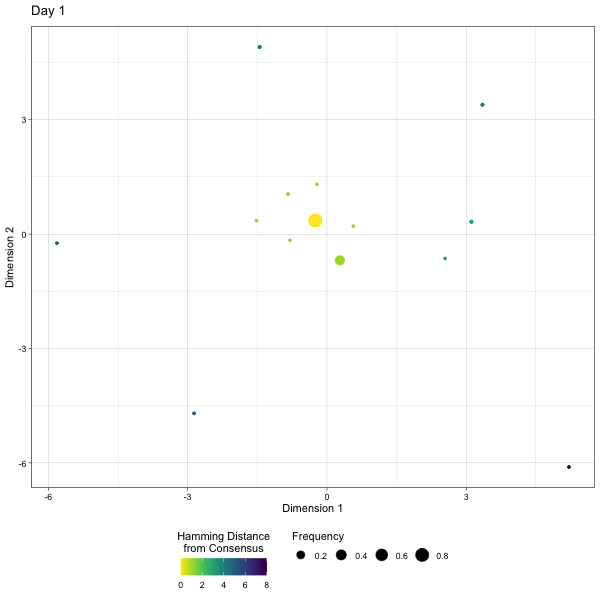

In [712]:
# Define the gif_path by replacing .csv with .gif in haps_path
gif_path = replace(haps_path, ".csv" => "_points.gif")

# Extract the directory name from gif_path
dir_path = dirname(gif_path)

# Ensure the directory exists
if !isdir(dir_path)
    mkpath(dir_path)  # Create the directory if it doesn't exist
end

# Pass the `grouped_haps` dataframe and `gif_path` to R
@rput grouped_haps
@rput gif_path

# Run the R code to create the animation and save it
R"""
# Find the min and max frequency
global_min <- min(grouped_haps$Frequency, na.rm = TRUE)
global_max <- max(grouped_haps$Frequency, na.rm = TRUE)

# Use these in ggplot with consistent size scale
size_limits <- c(global_min, global_max)
size_range <- c(0, 200)

# Create the ggplot
p <- grouped_haps %>%
    ggplot(aes(x = as.numeric(x), y = as.numeric(y), color = as.numeric(ham_dist), size = as.numeric(Frequency))) + 
    geom_point() +
    theme_linedraw() +
    labs(title = 'Day {round(frame_time)}', x = "Dimension 1", y = "Dimension 2",
        size = "Frequency", color = "Hamming Distance\nfrom Consensus") +
    guides(size = guide_legend(title.position = "top")) +
    theme(legend.position = "bottom") +
    guides(colour = guide_colourbar(title.position = "top", title.theme = element_text(hjust = 0.5))) +
    scale_color_viridis(direction = -1) +
    transition_time(as.numeric(Time)) +
    ease_aes('linear')

# Render the animation as a GIF
anim <- animate(p, renderer = gifski_renderer(), width = 600, height = 600, fps = 5, end_pause = 50)

# Save the GIF to the specified path
anim_save(gif_path, anim)
"""

using Base64, IJulia

# Check if the file was saved successfully
if isfile(gif_path)
    println("GIF successfully saved at $gif_path")
    
    # Read the GIF file
    gif_data = read(gif_path)
    
    # Encode the GIF data to base64
    base64_gif = base64encode(gif_data)
    
    # Create an HTML image tag with the base64-encoded GIF
    img_html = """<img src="data:image/gif;base64,$base64_gif" />"""
    
    # Display the HTML directly
    display(HTML(img_html))
else
    println("Failed to save GIF at $gif_path")
end